In [4]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt

In [5]:
#Paths
#My python installation on spirit: /home/ratlas/anaconda3/bin/ipython
#ERA5 files on spirit: /ciclad-home/legras/data/flexpart_in/ERA5/EN-true/ (note: there are seperate directories for each year)

In [ ]:
#Resources
#ERA5 documentation: https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation
#ERA5 paper: https://rmets.onlinelibrary.wiley.com/doi/10.1002/qj.3803

In [11]:
#Input surface pressure (sp)
#Output pressure in Pa for whole column
#See https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height

def compute_ERA5_pressure(sp):

    #Load in file with parameters
    data=np.loadtxt('ATTREX_ERA5/akbk.csv',skiprows=2,delimiter=',')

    #Read parameters into variables
    ak=np.concatenate(([0.0],data[:,1]))
    bk=np.concatenate(([0.0],data[:,2]))
    
    #Define pressure array
    ERA5_p=np.zeros(137)

    #Compute pressure level by level
    for j in range(137):
        ERA5_p[j]=.5*(ak[j]+bk[j]*sp)+.5*(ak[j+1]+bk[j+1]*sp)
    return ERA5_p

In [52]:
#Input surface pressure (sp) and column temperature (t)
#Output height in km for whole column
#See https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height

def compute_ERA5_z(sp,t):
        
    #We assume that humidity and surface geopotential is zero
    q=np.zeros(137)
    zp=0.0
    Rd=287.06
    
    data=np.loadtxt('ATTREX_ERA5/akbk.csv',skiprows=2,delimiter=',')

    ak=np.concatenate(([0.0],data[:,1]))
    bk=np.concatenate(([0.0],data[:,2]))
    
    ERA5_plev=ak[:-1]+bk[:-1]*sp
    ERA5_plevplusone=ak[1:]+bk[1:]*sp
        
    dlog_p=np.zeros(137)
    alpha=np.zeros(137)
        
    dlog_p[0] = np.log(ERA5_plevplusone[0]/ 0.1)
    alpha[0] = np.log(2)
        
    dlog_p[1:] = np.log(ERA5_plevplusone[1:]/ERA5_plev[1:])
    alpha[1:] = 1.-((ERA5_plev[1:]/(ERA5_plevplusone[1:]-ERA5_plev[1:]))*dlog_p[1:])
                
    t=t*(1+0.609133*q)*Rd
    
    z_hs=np.zeros(137)
    
    z_hs[136]=zp
    
    for i in np.arange(1,137):
        dz=t[136-i]*dlog_p[136-i]
        z_hs[136-i]=z_hs[136-i+1]+dz
                    
    return z_hs/(9.8*1e3)

In [9]:
example='ERA5EN20120201.grb'

In [56]:
#Read in an ERA5 grb file
#You need to install the cfgrib library to be able to run this
#Print the metadata
dataset=xr.open_dataset(example,engine='cfgrib')
print(dataset)

skipping variable: paramId==152 shortName='lnsp'
Traceback (most recent call last):
  File "C:\Users\ratlas\anaconda3\lib\site-packages\cfgrib\dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "C:\Users\ratlas\anaconda3\lib\site-packages\cfgrib\dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='hybrid' value=Variable(dimensions=('hybrid',), data=array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
 

<xarray.Dataset>
Dimensions:     (time: 8, hybrid: 137, latitude: 181, longitude: 360)
Coordinates:
  * time        (time) datetime64[ns] 2012-02-01 ... 2012-02-01T21:00:00
    step        timedelta64[ns] ...
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    t           (time, hybrid, latitude, longitude) float32 ...
    w           (time, hybrid, latitude, longitude) float32 ...
    u           (time, hybrid, latitude, longitude) float32 ...
    v           (time, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution

In [50]:
#Read in an ERA5 grb file and save variables
#You need to install the cfgrib library to be able to run this

#Note: I always get error messages when I open *grib files using
#xarray with the cfgrib engine but the files still load correctly

sp_dataset=xr.open_dataset(example,engine='cfgrib',\
                        backend_kwargs={'filter_by_keys':\
                                        {'shortName':'lnsp'}})

#log of surface pressure is given 
#in the *grb files and must be converted
sp=np.exp(xr.DataArray.to_numpy(sp_dataset['lnsp'][:])) #surface pressure in Pa

dataset=xr.open_dataset(example,engine='cfgrib')

latitude=xr.DataArray.to_numpy(dataset['latitude'][:])
longitude=xr.DataArray.to_numpy(dataset['longitude'][:])

T=xr.DataArray.to_numpy(dataset['t'][:]) #temperature [K]
w=xr.DataArray.to_numpy(dataset['w'][:]) #pressure velocity [Pa s-1]
u=xr.DataArray.to_numpy(dataset['u'][:]) #horizontal wind [m s-1]
v=xr.DataArray.to_numpy(dataset['v'][:]) #horizontal wind [m s-1]

skipping variable: paramId==152 shortName='lnsp'
Traceback (most recent call last):
  File "C:\Users\ratlas\anaconda3\lib\site-packages\cfgrib\dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "C:\Users\ratlas\anaconda3\lib\site-packages\cfgrib\dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='hybrid' value=Variable(dimensions=('hybrid',), data=array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
 

In [ ]:
#Create variables for the 3D pressure
p=np.zeros(np.shape(T))

#Compute pressure for each column using surface pressure
for hour in range(np.shape(p)[0]):
    for lat in range(np.shape(p)[2]):
        for lon in range(np.shape(p)[3]):
            p[hour,:,lat,lon]=compute_ERA5_pressure(sp[hour,lat,lon]) #Pa

In [53]:
#Create variables for the 3D height
height=np.zeros(np.shape(T))
            
#Compute height for each column using surface pressure
for hour in range(np.shape(p)[0]):
    for lat in range(np.shape(p)[2]):
        for lon in range(np.shape(p)[3]):
            height[hour,:,lat,lon]=compute_ERA5_z(sp[hour,lat,lon],T[hour,:,lat,lon]) #m

C:\Users\ratlas\AppData\Local\Temp\ipykernel_14984\1682197607.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


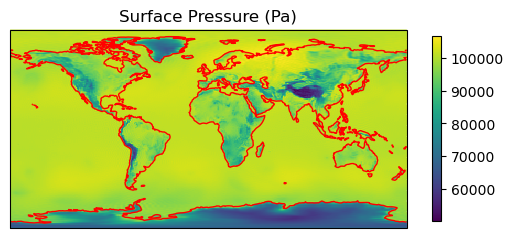

In [41]:
#Plot surface pressure from ERA5 for first hour in file on a map
fig=plt.figure()
projection = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.coastlines(color='r')
im=ax.pcolormesh(longitude,latitude,sp[0],transform=projection)
ax.set_title('Surface Pressure (Pa)')
fig.colorbar(im,shrink=.5)
fig.show()

C:\Users\ratlas\AppData\Local\Temp\ipykernel_14984\669673064.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


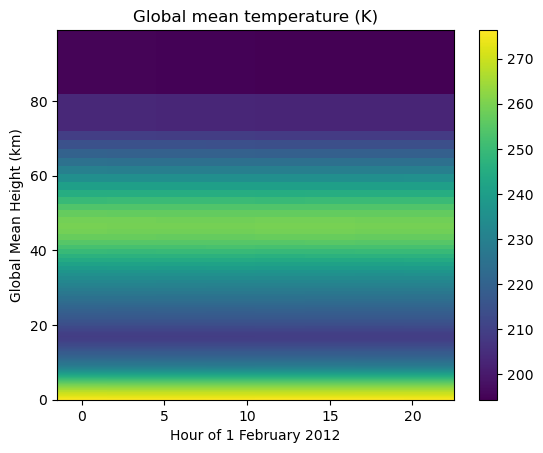

In [55]:
#Plot global mean temperature "curtain" (time-height plot)
fig,ax=plt.subplots()
im=ax.pcolormesh(np.linspace(0,21,8),np.mean(height,axis=(0,2,3)),np.transpose(np.mean(T,axis=(2,3))))
ax.set_title('Global mean temperature (K)')
ax.set_xlabel('Hour of 1 February 2012')
ax.set_ylabel('Global Mean Height (km)')
fig.colorbar(im)
fig.show()